In [1]:
# Function to generate serpentine positions across a 1280x720 grid
def generate_serpentine_positions(num_positions=20, width=1280, height=720):
    x_step = width // 5  # 5 horizontal steps
    y_step = height // 4  # 4 vertical steps (for 20 positions -> 4 rows)

    positions = []
    pos_count = 0

    # Generate positions with serpentine pattern
    for row in range(4):  # We want 4 rows of movement
        y = row * y_step
        if row % 2 == 0:  # Left to right on even rows
            for x in range(0, width, x_step):
                if pos_count < num_positions:
                    positions.append((x, y))
                    pos_count += 1
        else:  # Right to left on odd rows
            for x in range(width - x_step, -1, -x_step):
                if pos_count < num_positions:
                    positions.append((x, y))
                    pos_count += 1

    return positions

# Generate the list of positions
serpentine_positions = generate_serpentine_positions()
serpentine_positions


[(0, 0),
 (256, 0),
 (512, 0),
 (768, 0),
 (1024, 0),
 (1024, 180),
 (768, 180),
 (512, 180),
 (256, 180),
 (0, 180),
 (0, 360),
 (256, 360),
 (512, 360),
 (768, 360),
 (1024, 360),
 (1024, 540),
 (768, 540),
 (512, 540),
 (256, 540),
 (0, 540)]

Reading frames...
Total frames read: 200

Processing position 1/20: (0, 0)
Processing pixel time series...
Calculating Euclidean distances...
Normalizing distances...
Similarity Image - min: 0.0, max: 1.0, mean: 0.4452079236507416
Saved similarity_image_0_0.png for inspection.


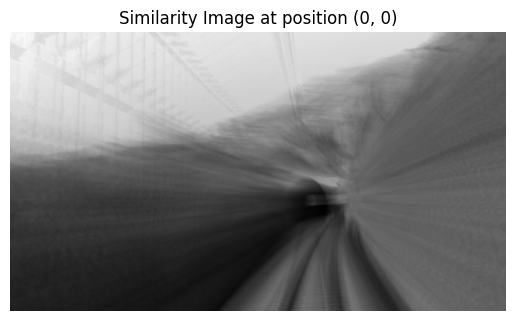

Creating threshold videos for position 1: 100%|████████████████████████████████████████| 14/14 [00:53<00:00,  3.80s/it]


Stitching videos together for position 1...


Stitching videos for position 1: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.95s/it]


Combined video saved as videos\combined_thresholds_video_pos_1.mp4.
Deleting non-combined videos for position 1...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_1.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_1.mp4
Deleted videos\euclidean_an

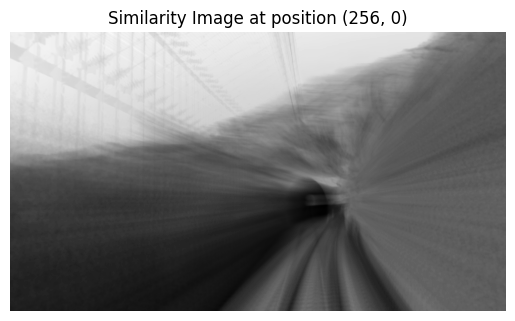

Creating threshold videos for position 2: 100%|████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


Stitching videos together for position 2...


Stitching videos for position 2: 100%|█████████████████████████████████████████████████| 14/14 [00:26<00:00,  1.89s/it]


Combined video saved as videos\combined_thresholds_video_pos_2.mp4.
Deleting non-combined videos for position 2...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_2.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_2.mp4
Deleted videos\euclidean_an

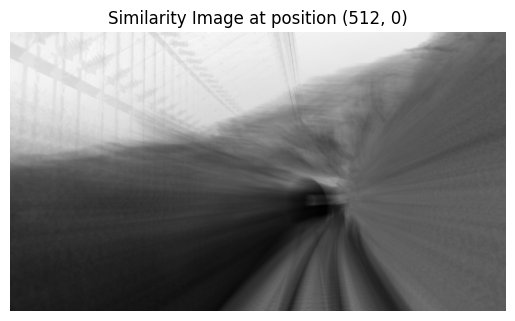

Creating threshold videos for position 3: 100%|████████████████████████████████████████| 14/14 [00:50<00:00,  3.63s/it]


Stitching videos together for position 3...


Stitching videos for position 3: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.99s/it]


Combined video saved as videos\combined_thresholds_video_pos_3.mp4.
Deleting non-combined videos for position 3...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_3.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_3.mp4
Deleted videos\euclidean_an

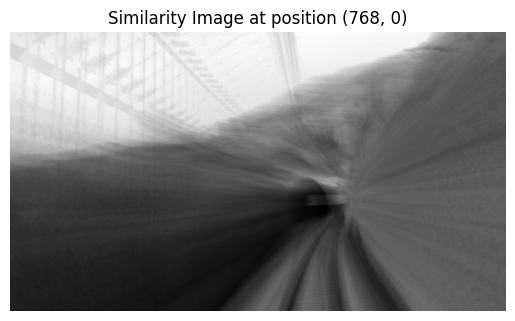

Creating threshold videos for position 4: 100%|████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


Stitching videos together for position 4...


Stitching videos for position 4: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.96s/it]


Combined video saved as videos\combined_thresholds_video_pos_4.mp4.
Deleting non-combined videos for position 4...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_4.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_4.mp4
Deleted videos\euclidean_an

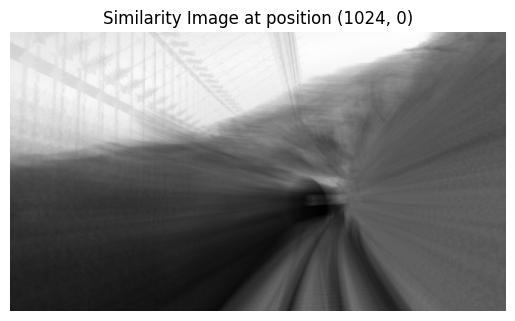

Creating threshold videos for position 5: 100%|████████████████████████████████████████| 14/14 [00:49<00:00,  3.57s/it]


Stitching videos together for position 5...


Stitching videos for position 5: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.99s/it]


Combined video saved as videos\combined_thresholds_video_pos_5.mp4.
Deleting non-combined videos for position 5...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_5.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_5.mp4
Deleted videos\euclidean_an

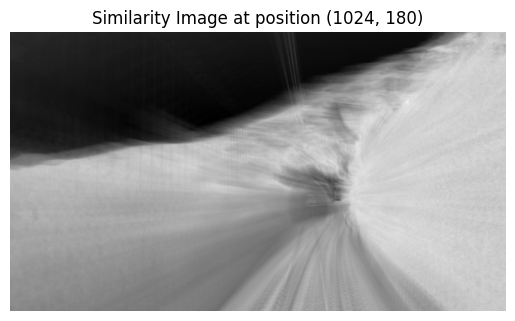

Creating threshold videos for position 6: 100%|████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


Stitching videos together for position 6...


Stitching videos for position 6: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.98s/it]


Combined video saved as videos\combined_thresholds_video_pos_6.mp4.
Deleting non-combined videos for position 6...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_6.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_6.mp4
Deleted videos\euclidean_an

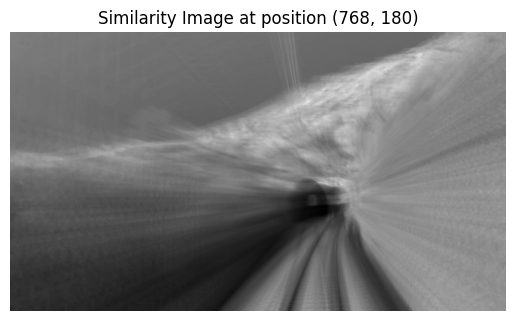

Creating threshold videos for position 7: 100%|████████████████████████████████████████| 14/14 [00:49<00:00,  3.56s/it]


Stitching videos together for position 7...


Stitching videos for position 7: 100%|█████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.81s/it]


Combined video saved as videos\combined_thresholds_video_pos_7.mp4.
Deleting non-combined videos for position 7...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_7.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_7.mp4
Deleted videos\euclidean_an

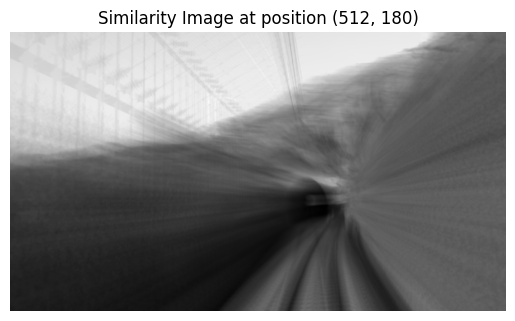

Creating threshold videos for position 8: 100%|████████████████████████████████████████| 14/14 [00:51<00:00,  3.69s/it]


Stitching videos together for position 8...


Stitching videos for position 8: 100%|█████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.98s/it]


Combined video saved as videos\combined_thresholds_video_pos_8.mp4.
Deleting non-combined videos for position 8...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_8.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_8.mp4
Deleted videos\euclidean_an

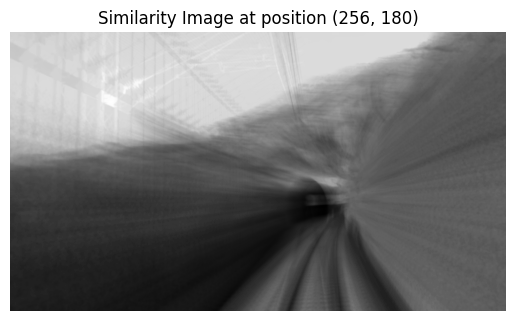

Creating threshold videos for position 9: 100%|████████████████████████████████████████| 14/14 [00:56<00:00,  4.06s/it]


Stitching videos together for position 9...


Stitching videos for position 9: 100%|█████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.01s/it]


Combined video saved as videos\combined_thresholds_video_pos_9.mp4.
Deleting non-combined videos for position 9...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_9.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_9.mp4
Deleted videos\euclidean_an

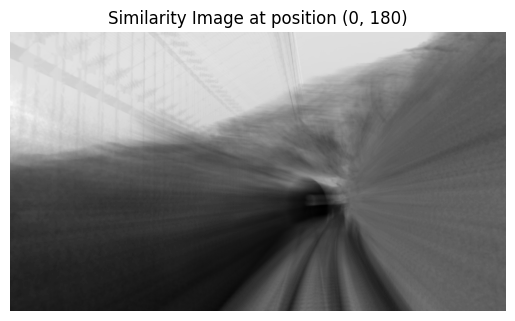

Creating threshold videos for position 10: 100%|███████████████████████████████████████| 14/14 [00:46<00:00,  3.33s/it]


Stitching videos together for position 10...


Stitching videos for position 10: 100%|████████████████████████████████████████████████| 14/14 [00:26<00:00,  1.88s/it]


Combined video saved as videos\combined_thresholds_video_pos_10.mp4.
Deleting non-combined videos for position 10...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_10.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_10.mp4
Deleted vide

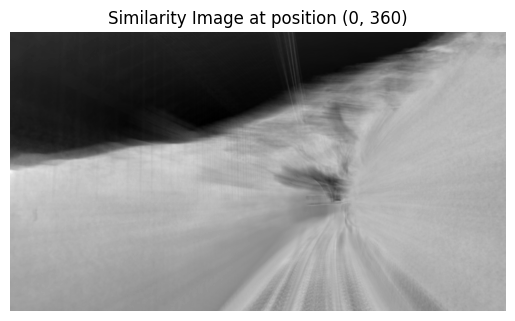

Creating threshold videos for position 11: 100%|███████████████████████████████████████| 14/14 [00:45<00:00,  3.25s/it]


Stitching videos together for position 11...


Stitching videos for position 11: 100%|████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.79s/it]


Combined video saved as videos\combined_thresholds_video_pos_11.mp4.
Deleting non-combined videos for position 11...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_11.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_11.mp4
Deleted vide

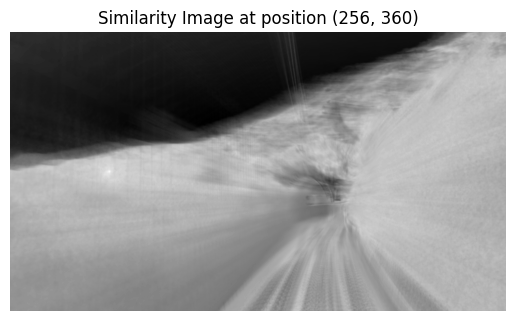

Creating threshold videos for position 12: 100%|███████████████████████████████████████| 14/14 [00:46<00:00,  3.33s/it]


Stitching videos together for position 12...


Stitching videos for position 12: 100%|████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.78s/it]


Combined video saved as videos\combined_thresholds_video_pos_12.mp4.
Deleting non-combined videos for position 12...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_12.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_12.mp4
Deleted vide

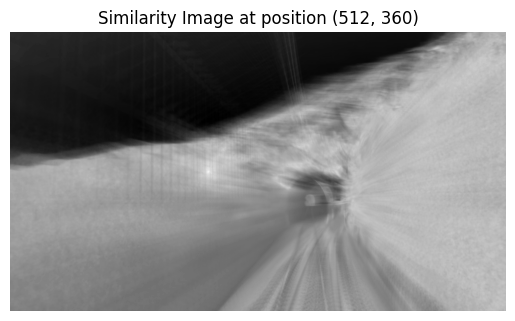

Creating threshold videos for position 13: 100%|███████████████████████████████████████| 14/14 [00:46<00:00,  3.29s/it]


Stitching videos together for position 13...


Stitching videos for position 13: 100%|████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.76s/it]


Combined video saved as videos\combined_thresholds_video_pos_13.mp4.
Deleting non-combined videos for position 13...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_13.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_13.mp4
Deleted vide

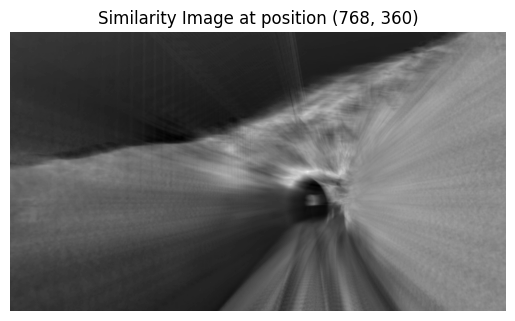

Creating threshold videos for position 14: 100%|███████████████████████████████████████| 14/14 [00:50<00:00,  3.63s/it]


Stitching videos together for position 14...


Stitching videos for position 14: 100%|████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.99s/it]


Combined video saved as videos\combined_thresholds_video_pos_14.mp4.
Deleting non-combined videos for position 14...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_14.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_14.mp4
Deleted vide

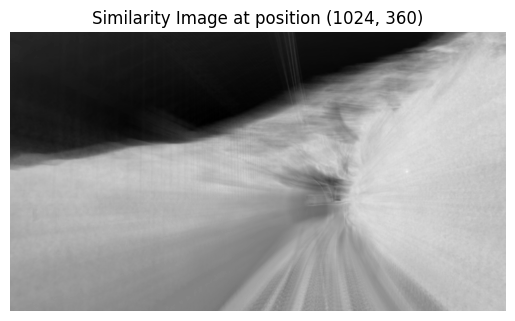

Creating threshold videos for position 15: 100%|███████████████████████████████████████| 14/14 [00:45<00:00,  3.22s/it]


Stitching videos together for position 15...


Stitching videos for position 15: 100%|████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.84s/it]


Combined video saved as videos\combined_thresholds_video_pos_15.mp4.
Deleting non-combined videos for position 15...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_15.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_15.mp4
Deleted vide

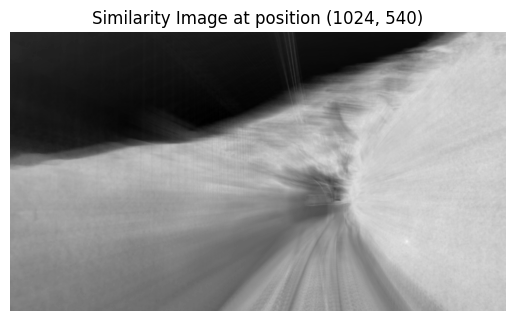

Creating threshold videos for position 16: 100%|███████████████████████████████████████| 14/14 [00:47<00:00,  3.37s/it]


Stitching videos together for position 16...


Stitching videos for position 16: 100%|████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.83s/it]


Combined video saved as videos\combined_thresholds_video_pos_16.mp4.
Deleting non-combined videos for position 16...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_16.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_16.mp4
Deleted vide

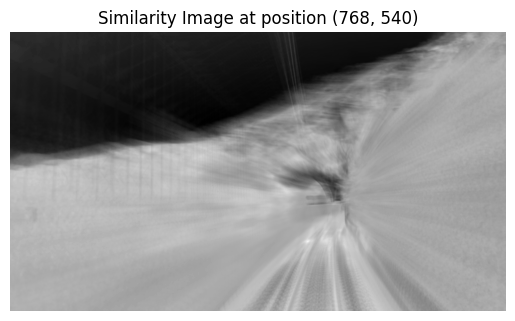

Creating threshold videos for position 17: 100%|███████████████████████████████████████| 14/14 [00:44<00:00,  3.16s/it]


Stitching videos together for position 17...


Stitching videos for position 17: 100%|████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.73s/it]


Combined video saved as videos\combined_thresholds_video_pos_17.mp4.
Deleting non-combined videos for position 17...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_17.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_17.mp4
Deleted vide

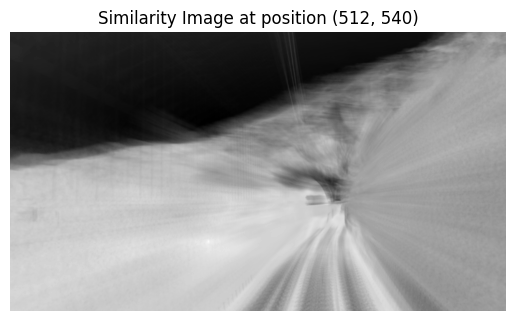

Creating threshold videos for position 18: 100%|███████████████████████████████████████| 14/14 [00:48<00:00,  3.50s/it]


Stitching videos together for position 18...


Stitching videos for position 18: 100%|████████████████████████████████████████████████| 14/14 [00:26<00:00,  1.90s/it]


Combined video saved as videos\combined_thresholds_video_pos_18.mp4.
Deleting non-combined videos for position 18...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_18.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_18.mp4
Deleted vide

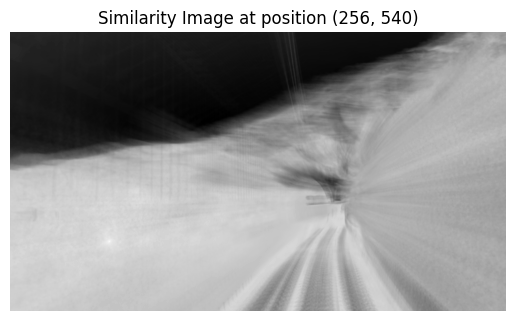

Creating threshold videos for position 19: 100%|███████████████████████████████████████| 14/14 [00:47<00:00,  3.36s/it]


Stitching videos together for position 19...


Stitching videos for position 19: 100%|████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.70s/it]


Combined video saved as videos\combined_thresholds_video_pos_19.mp4.
Deleting non-combined videos for position 19...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_19.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_19.mp4
Deleted vide

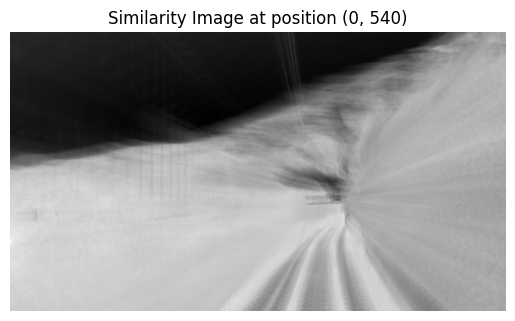

Creating threshold videos for position 20: 100%|███████████████████████████████████████| 14/14 [00:45<00:00,  3.26s/it]


Stitching videos together for position 20...


Stitching videos for position 20: 100%|████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.76s/it]

Combined video saved as videos\combined_thresholds_video_pos_20.mp4.
Deleting non-combined videos for position 20...
Deleted videos\euclidean_annotated_video_threshold_0.10_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.20_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.30_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.40_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.50_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.60_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.70_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.75_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.80_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.85_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.90_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.95_pos_20.mp4
Deleted videos\euclidean_annotated_video_threshold_0.98_pos_20.mp4
Deleted vide

In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt

def read_frames(input_video_path, num_frames=200, verbose=False):
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        if verbose:
            print("Error: Could not open video.")
        return None, None, None

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    ret, frame = cap.read()
    if not ret:
        if verbose:
            print("Failed to read the first frame of the video.")
        cap.release()
        return None, None, None

    height, width, channels = frame.shape
    frame_size = (height, width, channels)

    # Initialize array to store frames
    frames_array = []

    if verbose:
        print("Reading frames...")

    # Read the specified number of frames
    frame_count = 0
    while frame_count < num_frames:
        if frame is None:
            if verbose:
                print(f"Reached end of video at frame {frame_count}.")
            break
        frames_array.append(frame)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    num_frames = len(frames_array)

    if verbose:
        print(f"Total frames read: {num_frames}")

    # Convert frames list to numpy array
    frames_array = np.array(frames_array, dtype=np.uint8)  # Shape: (num_frames, height, width, 3)

    return frames_array, fps, frame_size

def compute_similarities(frames_array, position, verbose=False):
    # Extract dimensions
    num_frames, height, width, channels = frames_array.shape

    # Get the specified position
    center_x, center_y = position

    # Reshape frames to (height * width, num_frames * channels)
    if verbose:
        print("Processing pixel time series...")
    frames_reshaped = frames_array.transpose(1, 2, 0, 3).reshape(height * width, num_frames * channels)

    # Get the time series of the specified pixel
    center_index = center_y * width + center_x
    center_pixel_vector = frames_reshaped[center_index, :]

    # Compute Euclidean distances
    if verbose:
        print("Calculating Euclidean distances...")
    diffs = frames_reshaped.astype(np.float32) - center_pixel_vector.astype(np.float32)
    distances = np.linalg.norm(diffs, axis=1)

    # Normalize distances to get similarity (0 to 1)
    if verbose:
        print("Normalizing distances...")
    max_distance = distances.max()
    if max_distance == 0:
        if verbose:
            print("Max distance is zero. All pixels are identical to the specified pixel.")
        similarity = np.ones_like(distances)
    else:
        similarity = 1 - (distances / max_distance)

    # Reshape similarity back to image shape
    similarity_image = similarity.reshape(height, width)

    if verbose:
        print(f"Similarity Image - min: {similarity_image.min()}, max: {similarity_image.max()}, mean: {similarity_image.mean()}")

    # Optionally, save the similarity image for inspection
    similarity_visual = (similarity_image * 255).astype(np.uint8)
    cv2.imwrite(f'similarity_image_{center_x}_{center_y}.png', similarity_visual)
    if verbose:
        print(f"Saved similarity_image_{center_x}_{center_y}.png for inspection.")

    return similarity_image

def process_frames_for_threshold(frames_array, similarity_image, threshold, output_video_path, fps, frame_size, center_coords, dot_size=10):
    height, width, channels = frame_size
    center_x, center_y = center_coords
    num_frames = frames_array.shape[0]

    # Create mask for pixels based on threshold
    mask = (similarity_image >= threshold).astype(np.uint8)  # Shape: (height, width)
    num_masked_pixels = np.sum(mask)
    # print(f"Threshold: {threshold:.2f} - Number of pixels to overlay: {num_masked_pixels}")

    if num_masked_pixels == 0:
        print(f"No pixels found with similarity >= {threshold}. Skipping overlay.")
        # Proceed without overlay
        final_frames = frames_array.copy()
    else:
        # Initialize VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        for i in range(num_frames):
            frame = frames_array[i].copy()

            # Create an overlay image (white)
            overlay = np.full((height, width, channels), 255, dtype=np.uint8)

            # Apply the mask to the overlay
            mask_3channel = cv2.merge([mask, mask, mask])  # Convert to 3 channels

            # Blend the original frame with the overlay using the mask
            # Alpha determines the transparency: 0.0 - original, 1.0 - overlay
            alpha = 0.75  # 75% transparency

            # Apply blending only where mask is 1
            frame = np.where(mask_3channel == 1, cv2.addWeighted(frame, 1 - alpha, overlay, alpha, 0), frame)

            # Add red dot at the specified position in the frame
            cv2.circle(frame, (center_x, center_y), dot_size, (0, 0, 255), 1)

            # Add the threshold text
            text = f"similarity threshold: {threshold:.2f}"
            position_text = (width - 500, 50)  # Top-right position
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            color = (0, 0, 0)  # Black color for text
            thickness = 2
            cv2.putText(frame, text.lower(), position_text, font, font_scale, color, thickness, lineType=cv2.LINE_AA)

            out.write(frame)

        out.release()

def main():
    input_video_path = 'cab_ride_trimmed.mkv'
    output_dir = 'videos'
    num_frames = 200
    verbose = True  # Set to True for detailed logs

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory at '{output_dir}'.")

    # Read frames once
    frames_array, fps, frame_size = read_frames(input_video_path, num_frames=num_frames, verbose=verbose)

    if frames_array is None:
        print("Failed to read frames.")
        return

    height, width, channels = frame_size

    # Sweep 20 positions in serpentine fashion
    num_positions = 20
    positions = generate_serpentine_positions(num_positions, width, height)

    # For each position, compute similarities and create videos
    for pos_idx, position in enumerate(positions):
        print(f"\nProcessing position {pos_idx+1}/{num_positions}: {position}")
        similarity_image = compute_similarities(frames_array, position, verbose=verbose)

        # Visualize the similarity image
        plt.imshow((similarity_image * 255).astype(np.uint8), cmap='gray')
        plt.title(f'Similarity Image at position {position}')
        plt.axis('off')  # Hide the axes
        plt.show()

        # Create multiple videos for different thresholds
        threshold_values = [0.99, 0.98, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

        for idx, threshold in enumerate(tqdm(threshold_values, desc=f"Creating threshold videos for position {pos_idx+1}")):
            output_path = os.path.join(output_dir, f'euclidean_annotated_video_threshold_{threshold:.2f}_pos_{pos_idx+1}.mp4')
            current_dot_size = 10  # Fixed dot size of 10
            process_frames_for_threshold(
                frames_array, similarity_image, threshold, output_path, fps, frame_size, position, dot_size=current_dot_size)

        # Stitch all videos together for this position
        print(f"Stitching videos together for position {pos_idx+1}...")
        output_combined_path = os.path.join(output_dir, f'combined_thresholds_video_pos_{pos_idx+1:03d}.mp4')
        video_pattern = os.path.join(output_dir, f'euclidean_annotated_video_threshold_*_pos_{pos_idx+1}.mp4')
        video_files = sorted(glob.glob(video_pattern))

        if not video_files:
            print("No video files found to stitch.")
            continue

        # Get properties from the first video
        cap = cv2.VideoCapture(video_files[0])
        if not cap.isOpened():
            print("Error: Could not open the first video for stitching.")
            continue

        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out_combined = cv2.VideoWriter(output_combined_path, fourcc, fps, (width, height))

        for video_file in tqdm(video_files, desc=f"Stitching videos for position {pos_idx+1}"):
            cap = cv2.VideoCapture(video_file)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_file}")
                continue

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                out_combined.write(frame)
            cap.release()

        out_combined.release()
        print(f"Combined video saved as {output_combined_path}.")

        # Delete the non-combined videos for this position
        print(f"Deleting non-combined videos for position {pos_idx+1}...")
        for video_file in video_files:
            try:
                os.remove(video_file)
                print(f"Deleted {video_file}")
            except OSError as e:
                print(f"Error: Could not delete {video_file}. {e}")

if __name__ == '__main__':
    main()
